# Исследование Яндекс.Афиши

В данном проекте мы анализируем данные сервиса Яндекс.Афиши.  
Цель проекта: дать маркетологам рекомендации относительно того, на каких источниках трафика стоит сконцентрировать внимание.  
Для анализа нам доступны данные о посещении сервиса пользователями, выгрузка всех заказов за период, статистика рекламных расходов. 

## Предобработка данных

Загрузим файлы с данными

In [197]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

In [198]:
#В проекте использован датасет предоставленный Яндекс.Практикум
visits = pd.read_csv('/***/***.csv')

In [199]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [200]:
#В проекте использован датасет предоставленный Яндекс.Практикум
orders = pd.read_csv('/***/***.csv')

In [201]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [202]:
#В проекте использован датасет предоставленный Яндекс.Практикум
costs = pd.read_csv('/***/***.csv')

In [203]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [204]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [205]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [206]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Во всех датафреймах даты хранятся в формате object, при расчетах нужно будет переводить данные в формат даты.  
Пропусков в данных нет

Переименуем столбцы в visits и orders

In [207]:
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

In [208]:
orders = orders.rename(columns={"buy ts": "buy_ts"})

In [209]:
orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [210]:
visits = visits.rename(columns={"end ts": "end_ts", "source id": "source_id", "start ts": "start_ts"})

In [211]:
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

## Продуктовые метрики

### Рассчитываем показатели DAU, WAU и MAU. 

 
Сперва переведем данные о времени начала и окончания сессии в формат даты


In [212]:
visits['start_ts'] = pd.to_datetime(
    visits['start_ts'], format="%Y-%m-%d %H:%M")
visits['end_ts'] = pd.to_datetime(
    visits['end_ts'], format="%Y-%m-%d %H:%M")

In [213]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] =  visits['start_ts'].dt.week
visits['session_date'] =  visits['start_ts'].dt.date

In [214]:
dau = visits.groupby('session_date').agg({'uid':'nunique'})

In [215]:
dau.head()

,uid
session_date,
2017-06-01,605
2017-06-02,608
2017-06-03,445
2017-06-04,476
2017-06-05,820


In [216]:
dau_total = (visits.groupby('session_date').agg({'uid':'nunique'}).mean())

In [217]:
dau_total

uid    907.991758
dtype: float64

In [218]:
wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})

In [219]:
wau.head()

uid
session_year session_week      
2017         22            2021
             23            4129
             24            2812
             25            2878
             26            3064

In [220]:
wau_total = wau.mean()

In [221]:
wau_total

uid    5716.245283
dtype: float64

In [222]:
mau = visits.groupby(['session_year','session_month']).agg({'uid':'nunique'})

In [223]:
mau.head(10)

uid
session_year session_month       
2017         6              13259
             7              14183
             8              11631
             9              18975
             10             29692
             11             32797
             12             31557
2018         1              28716
             2              28749
             3              27473

In [224]:
mau_total = mau.mean()

In [225]:
mau_total

uid    23228.416667
dtype: float64

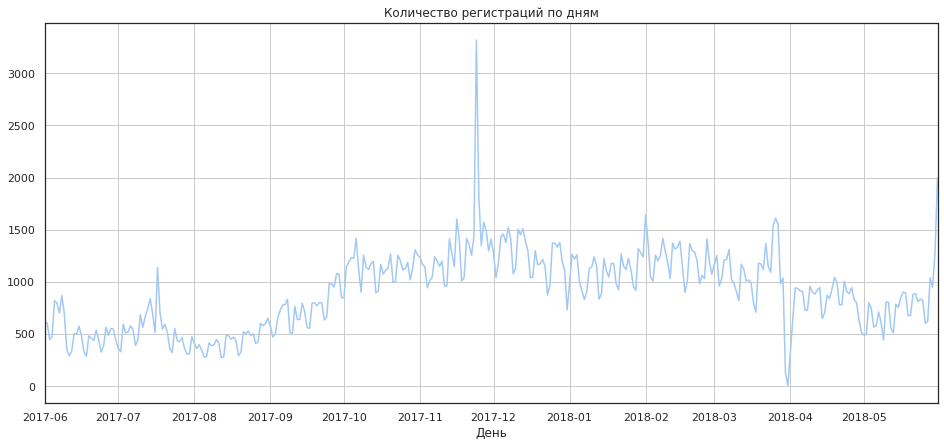

In [226]:
ax = dau.plot(kind='line', figsize = (16,7),  grid=True, legend=None)
fmt_month = mdates.MonthLocator()
ax.xaxis.set_major_locator(fmt_month)
ax.set_xlabel('День')
ax.set_title('Количество регистраций по дням')
plt.show()

С июля 2017го года до октября 2017го на сайте регистрировалось около 500 пользователей в день. Затем в период с октября 2017 до апреля 2018 - около 1200 пользователей в день, после чего количество регистраций вновь упало и колебалось в диапозоне от 500 до 1000 до июля 2018го.  
Наблюдаются пики в ноябре 2017го и в конце мая 2018гою Также в марте 2018го есть один день с нудевым количеством регистраций - возможно, сервис в этот день не работал, или была проблема с регистрацией.
В среднем за рассматриваемый период регистрировалось по 908 пользователей в день.

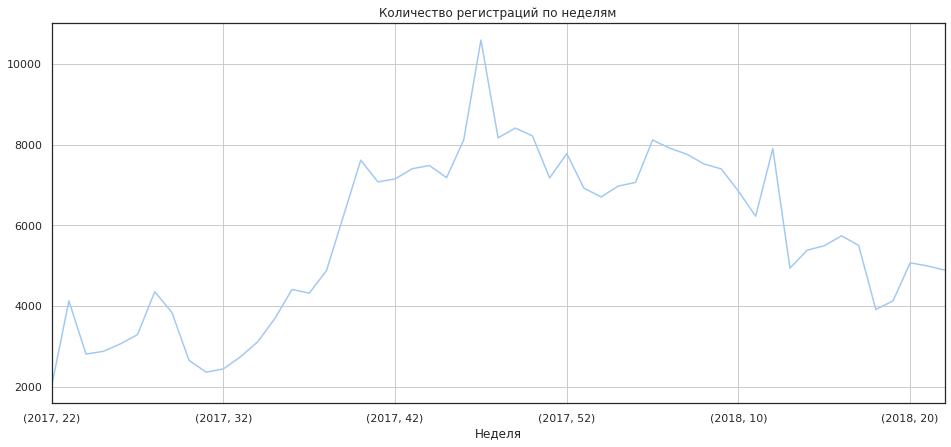

In [227]:
ax_w = wau.plot(kind='line', figsize = (16,7),  grid=True, legend=None)
ax_w.set_xlabel('Неделя')
ax_w.set_title('Количество регистраций по неделям')
plt.show()

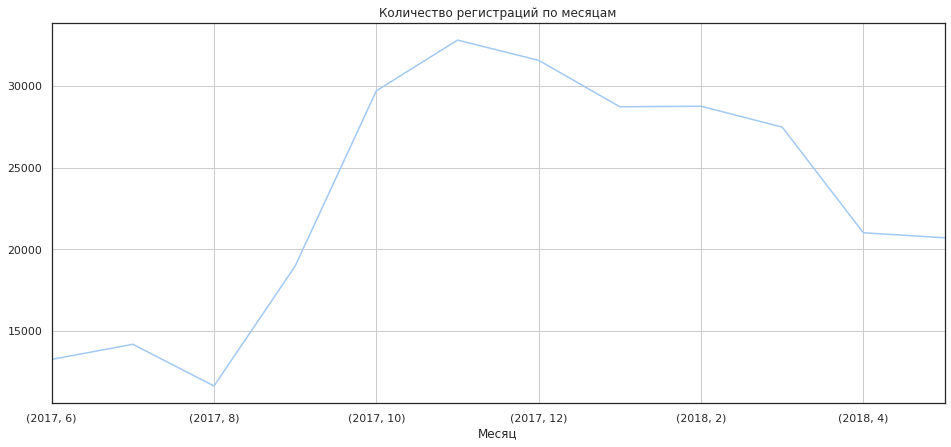

In [228]:
ax_m = mau.plot(kind='line', figsize = (16,7),  grid=True, legend=None)
ax_m.set_xlabel('Месяц')
ax_m.set_title('Количество регистраций по месяцам')
plt.show()

### Определим, сколько раз за день пользователи в среднем заходят на сайт.

In [229]:
sessions_per_user = visits.groupby(['session_date']).agg(
    {'uid': ['count', 'nunique']}
)
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = (
    sessions_per_user['n_sessions'] / sessions_per_user['n_users']
)
sessions_per_user = sessions_per_user.reset_index()
print(sessions_per_user.head()) 

  session_date  n_sessions  n_users  sessions_per_user
0   2017-06-01         664      605           1.097521
1   2017-06-02         658      608           1.082237
2   2017-06-03         477      445           1.071910
3   2017-06-04         510      476           1.071429
4   2017-06-05         893      820           1.089024


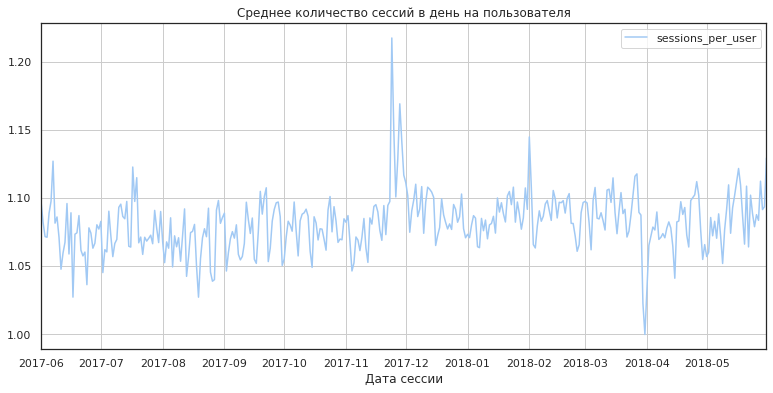

In [230]:
ax_s = sessions_per_user.plot('session_date', 'sessions_per_user', grid=True, figsize=(13,6), 
                              title = 'Среднее количество сессий в день на пользователя')
ax_s.set_xlabel('Дата сессии')
plt.show()

Среднее количество сессий в день на одного пользователя достаточно стабильно на всём периоде наблюдений и колеблется от 1.05 до 1.1 сессии в день.

### Исследуем, сколько времени пользователи проводят на сайте.
Рассчитаем среднее время сессии.

In [231]:
visits['session_duration_sec'] = (
    visits['end_ts'] - visits['start_ts']
).dt.seconds
print(visits['session_duration_sec'].mean()) 

643.506488592098


В среднем пользователи проводят на сайте около 10 с половиной минут.
Взглянем на распределение.


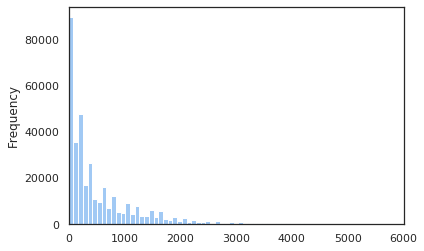

In [232]:
visits['session_duration_sec'].plot.hist(bins=1000, xlim = (0,6000));

Длительность сессий распределена не нормально. Для определения типичной длины сессии используем медиану. 

In [233]:
print(visits['session_duration_sec'].median())

300.0


Типичный пользователь проводит на сайте 5 минут.

### Рассчитаем Retention Rate

In [234]:
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.merge(first_activity_date,on='uid', how = 'left') 

In [235]:
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,0,2017-12-27
...,...,...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29,19,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25,19,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03,19,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02,19,2017-11-02


In [236]:
visits['first_session_month'] = visits['first_activity_date'].astype('datetime64[M]')

In [237]:
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')

In [238]:
cohort_grouped = visits.groupby('first_session_month').agg(
    {'uid': 'nunique'}
)

In [239]:
cohort_grouped

,uid
first_session_month,
2017-06-01,13259
2017-07-01,13140
2017-08-01,10181
2017-09-01,16704
2017-10-01,25977
2017-11-01,27248
2017-12-01,25268
2018-01-01,22624
2018-02-01,22197


In [240]:
visits_grouped_by_cohorts = visits.groupby(
    ['first_session_month', 'activity_month']
).agg({'uid': 'nunique'})

In [241]:
visits_grouped_by_cohorts

uid
first_session_month activity_month       
2017-06-01          2017-06-01      13259
                    2017-07-01       1043
                    2017-08-01        713
                    2017-09-01        814
                    2017-10-01        909
...                                   ...
2018-03-01          2018-04-01        861
                    2018-05-01        557
2018-04-01          2018-04-01      15709
                    2018-05-01        760
2018-05-01          2018-05-01      15273

[78 rows x 1 columns]

In [242]:
visits['cohort_lifetime'] = visits['activity_month'] - visits['first_session_month']

In [243]:
visits['cohort_lifetime'] = (visits['cohort_lifetime']/ np.timedelta64(1, 'M')).round().astype('int')

In [244]:
cohorts = visits.groupby(['first_session_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [245]:
cohorts.head(10)

,first_session_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909
5,2017-06-01,5,947
6,2017-06-01,6,809
7,2017-06-01,7,766
8,2017-06-01,8,694
9,2017-06-01,9,674


In [246]:
visits.pivot_table(
    index='first_session_month',
    columns='activity_month',
    values='uid',
    aggfunc='nunique',
) 

activity_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_session_month,,,,,,,,,,,,
2017-06-01,13259.0,1043.0,713.0,814.0,909.0,947.0,809.0,766.0,694.0,674.0,539.0,596.0
2017-07-01,NaN,13140.0,737.0,674.0,738.0,765.0,633.0,596.0,601.0,510.0,376.0,361.0
2017-08-01,NaN,NaN,10181.0,783.0,640.0,639.0,510.0,448.0,370.0,402.0,284.0,265.0
2017-09-01,NaN,NaN,NaN,16704.0,1428.0,1156.0,847.0,658.0,632.0,599.0,404.0,381.0
2017-10-01,NaN,NaN,NaN,NaN,25977.0,2042.0,1357.0,1012.0,890.0,837.0,555.0,529.0
2017-11-01,NaN,NaN,NaN,NaN,NaN,27248.0,2133.0,1202.0,1054.0,919.0,638.0,594.0
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,25268.0,1410.0,960.0,786.0,512.0,481.0
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22624.0,1351.0,890.0,565.0,458.0
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22197.0,1267.0,565.0,446.0


Посчитаем для каждой когорты начальное количество пользователей

In [247]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][
    ['first_session_month', 'uid']
]

In [248]:
initial_users_count = initial_users_count.rename(columns = {'uid':'cohort_users'})

In [249]:
initial_users_count

,first_session_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977
50,2017-11-01,27248
57,2017-12-01,25268
63,2018-01-01,22624
68,2018-02-01,22197
72,2018-03-01,20589


Добавим полученный результат в датафрейм с когортами

In [250]:
cohorts = cohorts.merge(initial_users_count, on = 'first_session_month')

In [251]:
cohorts.head()

,first_session_month,cohort_lifetime,uid,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


Посчитаем Retention

In [252]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [253]:
cohorts.head(10)

,first_session_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557
5,2017-06-01,5,947,13259,0.071423
6,2017-06-01,6,809,13259,0.061015
7,2017-06-01,7,766,13259,0.057772
8,2017-06-01,8,694,13259,0.052342
9,2017-06-01,9,674,13259,0.050833


In [254]:
retention_pivot = cohorts.pivot_table(
    index='first_session_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum',
) 

In [255]:
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Построим тепловую карту retention rate по месяцам жизни когорт.

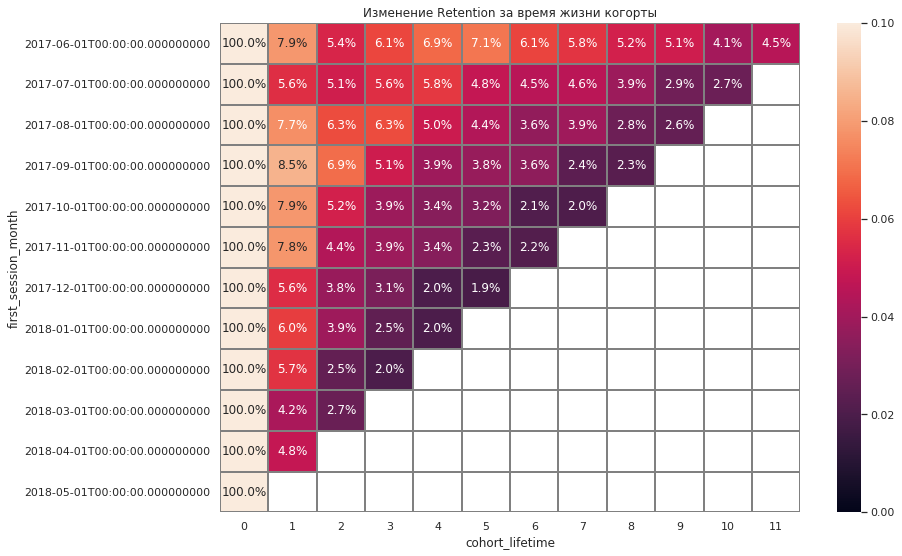

In [256]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение Retention за время жизни когорты')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray',  vmin = 0.00,vmax=0.1); 

Видно, что Retention rate ниже в более молодых когортах (снижается с декабря 2017го). Для 1го месяца жизни когорты retention rate снизился примерно с 8 до 5%.   
Также в рамках каждой когорты в целом наблюдается постепенное снижение retention rate, хотя в двух первых когортах в некоторых месяцах был небольшой рост. При том чем моложе когорта, тем быстрее снижается retention rate. К примеру в первых двух когортах на 6й месяц оставалось 5-6% пользователей, а в 4 и 5й когортах только около 2%.

Найдём средний Retention Rate на второй месяц «жизни» когорт

In [257]:
ret2 = cohorts.query('cohort_lifetime == 1')['retention'].mean()
print('Средний Retention Rate на второй месяц «жизни» когорт: {:.1%}'.format(ret2))

Средний Retention Rate на второй месяц «жизни» когорт: 6.5%


### Выводы

С июля 2017го года до октября 2017го на сайте регистрировалось около 500 пользователей в день. Затем в период с октября 2017 до апреля 2018 - около 1200 пользователей в день, после чего количество регистраций вновь упало и колебалось в диапозоне от 500 до 1000 до июля 2018го.
Наблюдаются пики в ноябре 2017го и в конце мая 2018гою Также в марте 2018го есть один день с нудевым количеством регистраций - возможно, сервис в этот день не работал, или была проблема с регистрацией. В среднем за рассматриваемый период регистрировалось по 908 пользователей в день.  

Среднее количество сессий в день на одного пользователя достаточно стабильно на всём периоде наблюдений и колеблется от 1.05 до 1.1 сессии в день.  
Типичный пользователь проводит на сайте 5 минут.

Retention rate ниже в более молодых когортах (снижается с декабря 2017го). Для 1го месяца жизни когорты retention rate снизился примерно с 8 до 5%.   
Также в рамках каждой когорты в целом наблюдается постепенное снижение retention rate, хотя в двух первых когортах в некоторых месяцах был небольшой рост. При том чем моложе когорта, тем быстрее снижается retention rate. К примеру в первых двух когортах на 6й месяц оставалось 5-6% пользователей, а в 4 и 5й когортах только около 2%.  
Средний Retention Rate на второй месяц «жизни» когорт: 6.5%


## Метрики электронной коммерции

### Изучим, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки. 

Найдем время первого заказа для каждого пользователя

In [258]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [259]:
first_order = orders.groupby('uid')['buy_ts'].min().reset_index()

In [260]:
first_order = first_order.rename(columns={'buy_ts':'first_order_ts'})

In [261]:
first_order.head()

,uid,first_order_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00


Найдём время первого посещения

In [262]:
first_activity_start_ts = visits.groupby(['uid'])['start_ts'].min().reset_index()

In [263]:
first_activity_start_ts = first_activity_start_ts.rename(columns = {'start_ts':'first_start_ts'})

In [264]:
first_activity_start_ts.head()

,uid,first_start_ts
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


Добавим полученные данные в один датафрейм

In [265]:
first_activity = pd.merge(first_order, first_activity_start_ts, on = 'uid')

In [266]:
first_activity['time_to_order'] = first_activity['first_order_ts'] - first_activity['first_start_ts']

In [267]:
first_activity.head()

,uid,first_order_ts,first_start_ts,time_to_order
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,106 days 23:02:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0 days 00:00:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,0 days 01:19:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,0 days 19:44:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0 days 00:00:00


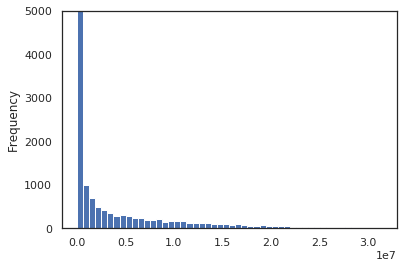

In [268]:
(first_activity['time_to_order'] / np.timedelta64(1, 's')).plot.hist(bins=50, ylim=(0,5000));

In [269]:
time_to_order = first_activity['time_to_order'].median()
print ('Медианное время до первой покупки: {}'.format(time_to_order))

Медианное время до первой покупки: 0 days 00:16:00


### Рассчитываем среднее количество покупок на одного покупателя за 6 месяцев

Добавим в датафрейм с заказами когорту пользователя
 

Добавим когорты на основании даты первого заказа.

In [270]:
first_purchase_date = orders.groupby(['uid'])['buy_ts'].min()
first_purchase_date.name = 'first_purchase_date'
orders = orders.join(first_purchase_date,on='uid') 

In [271]:
orders['first_purchase_month'] = orders['first_purchase_date'].astype('datetime64[M]')

In [272]:
orders.head()

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01


Рассчитаем lifetime для когорт

In [273]:
orders['month'] = orders['buy_ts'].astype('datetime64[M]')

In [274]:
orders.head()

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


In [275]:
orders['first_purchase_lifetime'] = orders['month'] - orders['first_purchase_month']

In [276]:
orders['first_purchase_lifetime'] = (orders['first_purchase_lifetime']/ np.timedelta64(1, 'M')).round().astype('int')

Посчитаем количество заказов в кажом месяце жизни когорты

In [277]:
orders_grouped = orders.groupby(['first_purchase_month','first_purchase_lifetime']).agg(
    {'uid':'count'}).reset_index()

In [278]:
orders_grouped.head(13)

,first_purchase_month,first_purchase_lifetime,uid
0,2017-06-01,0,2354
1,2017-06-01,1,177
2,2017-06-01,2,174
3,2017-06-01,3,226
4,2017-06-01,4,292
5,2017-06-01,5,218
6,2017-06-01,6,276
7,2017-06-01,7,174
8,2017-06-01,8,212
9,2017-06-01,9,153


Посчитаем кумулятивное количество заказов по месяцам жизни когорт

In [279]:
orders_grouped['cum_purchases'] = orders_grouped.groupby(['first_purchase_month'])['uid'].cumsum(axis=0)

In [280]:
orders_grouped.head(13)

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases
0,2017-06-01,0,2354,2354
1,2017-06-01,1,177,2531
2,2017-06-01,2,174,2705
3,2017-06-01,3,226,2931
4,2017-06-01,4,292,3223
5,2017-06-01,5,218,3441
6,2017-06-01,6,276,3717
7,2017-06-01,7,174,3891
8,2017-06-01,8,212,4103
9,2017-06-01,9,153,4256


Добавим количество пользователей в когортах

In [281]:
buyers_cohorts = orders.groupby(['first_purchase_month','first_purchase_lifetime']).agg({'uid':'nunique'}).reset_index()

In [282]:
buyers_cohorts.head()

,first_purchase_month,first_purchase_lifetime,uid
0,2017-06-01,0,2023
1,2017-06-01,1,61
2,2017-06-01,2,50
3,2017-06-01,3,54
4,2017-06-01,4,88


In [283]:
initial_buyers_count = buyers_cohorts[buyers_cohorts['first_purchase_lifetime'] == 0][
    ['first_purchase_month', 'uid']
]

In [284]:
initial_buyers_count = initial_buyers_count.rename(columns = {'uid':'cohort_buyers_users'})

In [285]:
initial_buyers_count

,first_purchase_month,cohort_buyers_users
0,2017-06-01,2023
12,2017-07-01,1923
23,2017-08-01,1370
33,2017-09-01,2581
42,2017-10-01,4340
50,2017-11-01,4081
57,2017-12-01,4383
63,2018-01-01,3373
68,2018-02-01,3651
72,2018-03-01,3533


In [286]:
 orders_grouped = orders_grouped.merge(initial_buyers_count, on = 'first_purchase_month')

Рассчитаем среднее количество покупок на одного пользователя на каждый месяц жизни когорты.  
Посмотрим на показатель на 6й месяц.

In [287]:
orders_grouped['purchases_mean'] = orders_grouped['cum_purchases'] / orders_grouped['cohort_buyers_users']

In [288]:
orders_grouped.head(20)

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases,cohort_buyers_users,purchases_mean
0,2017-06-01,0,2354,2354,2023,1.163618
1,2017-06-01,1,177,2531,2023,1.251112
2,2017-06-01,2,174,2705,2023,1.337123
3,2017-06-01,3,226,2931,2023,1.448838
4,2017-06-01,4,292,3223,2023,1.593178
5,2017-06-01,5,218,3441,2023,1.700939
6,2017-06-01,6,276,3717,2023,1.837370
7,2017-06-01,7,174,3891,2023,1.923381
8,2017-06-01,8,212,4103,2023,2.028176
9,2017-06-01,9,153,4256,2023,2.103806


In [289]:
orders_grouped.query('first_purchase_lifetime == 6')

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases,cohort_buyers_users,purchases_mean
6,2017-06-01,6,276,3717,2023,1.837370
18,2017-07-01,6,61,2725,1923,1.417057
29,2017-08-01,6,49,2018,1370,1.472993
39,2017-09-01,6,108,3761,2581,1.457187
48,2017-10-01,6,86,5880,4340,1.354839
56,2017-11-01,6,102,5900,4081,1.445724


Пользователи 1й горты (июнь 2017го) оформили за 6 месяцев в среднем по 1,83 заказа.  
У остальных когорт результаты близки - от 1,35 до 1,47 заказа. Худший показатель у когорты октября 2017го - 1,35. 

Посчитаем среднее по всем когортам на 6й месяц жизни

In [290]:
orders_grouped.query('first_purchase_lifetime == 6')['cum_purchases'].sum()/orders_grouped.query('first_purchase_lifetime == 6')['cohort_buyers_users'].sum()

1.4708297585488417

В среднем по всем когортам за 6 месяцев подбзователи оформили по 1.47 заказа.

### Рассчитываем средний чек

Посмотрим как изменялся средний чек по месяцам

In [291]:
orders.groupby('month')['revenue'].mean()

month
2017-06-01    4.060106
2017-07-01    5.306589
2017-08-01    4.847139
2017-09-01    5.416448
2017-10-01    4.928280
2017-11-01    4.783518
2017-12-01    5.852139
2018-01-01    4.112927
2018-02-01    4.840095
2018-03-01    5.413930
2018-04-01    5.150645
2018-05-01    4.771279
2018-06-01    3.420000
Name: revenue, dtype: float64

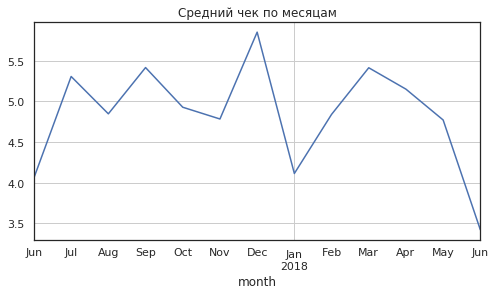

In [292]:
orders.groupby('month')['revenue'].mean().plot(kind = 'line', grid=True,figsize=(8,4), title = 'Средний чек по месяцам');

Средний чек изменяется по месяцам в пределах 4-6 у.е., но устойчивой тенденции к повышению или понижению не наблюдается.  
Самый большой средний чек в декабре 2017го, 5.85 у.е., самый маленький - в июне 2017го, 4.06 у.е.  
В июне 2018го средний чек 3.42 у.е., но за этот месяц есть данные только об одном заказе, поэтому они не показательны.

### Изучаем изменение LTV на покупателя по когортам

In [293]:
orders_grouped

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases,cohort_buyers_users,purchases_mean
0,2017-06-01,0,2354,2354,2023,1.163618
1,2017-06-01,1,177,2531,2023,1.251112
2,2017-06-01,2,174,2705,2023,1.337123
3,2017-06-01,3,226,2931,2023,1.448838
4,2017-06-01,4,292,3223,2023,1.593178
...,...,...,...,...,...,...
74,2018-03-01,2,176,4484,3533,1.269176
75,2018-04-01,0,2495,2495,2276,1.096221
76,2018-04-01,1,195,2690,2276,1.181898
77,2018-05-01,0,3249,3249,2988,1.087349


In [294]:
orders

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month,first_purchase_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0
...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0


In [295]:
cumrevenue = orders.groupby(['first_purchase_month', 'first_purchase_lifetime']).agg({'revenue': 'sum'}).reset_index()

In [296]:
cumrevenue.head()

,first_purchase_month,first_purchase_lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58


In [297]:
orders_grouped['revenue'] = cumrevenue['revenue']

In [298]:
orders_grouped['revenue_per_user'] = orders_grouped['revenue'] / orders_grouped['cohort_buyers_users']

In [299]:
orders_grouped['ltv'] = orders_grouped.groupby(['first_purchase_month'])['revenue_per_user'].cumsum(axis=0)

In [300]:
orders_grouped.head(20)

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases,cohort_buyers_users,purchases_mean,revenue,revenue_per_user,ltv
0,2017-06-01,0,2354,2354,2023,1.163618,9557.49,4.724414,4.724414
1,2017-06-01,1,177,2531,2023,1.251112,981.82,0.485329,5.209743
2,2017-06-01,2,174,2705,2023,1.337123,885.34,0.437637,5.647380
3,2017-06-01,3,226,2931,2023,1.448838,1931.30,0.954671,6.602051
4,2017-06-01,4,292,3223,2023,1.593178,2068.58,1.022531,7.624582
5,2017-06-01,5,218,3441,2023,1.700939,1487.92,0.735502,8.360084
6,2017-06-01,6,276,3717,2023,1.837370,1922.74,0.950440,9.310524
7,2017-06-01,7,174,3891,2023,1.923381,1176.56,0.581592,9.892116
8,2017-06-01,8,212,4103,2023,2.028176,1119.15,0.553213,10.445329
9,2017-06-01,9,153,4256,2023,2.103806,1225.51,0.605788,11.051117


Посмотрим на средний LTV на 6й месяц жизни когорт

In [301]:
orders_grouped.query('first_purchase_lifetime == 5')

,first_purchase_month,first_purchase_lifetime,uid,cum_purchases,cohort_buyers_users,purchases_mean,revenue,revenue_per_user,ltv
5,2017-06-01,5,218,3441,2023,1.700939,1487.92,0.735502,8.360084
17,2017-07-01,5,82,2664,1923,1.385335,300.08,0.156048,7.660775
28,2017-08-01,5,62,1969,1370,1.437226,388.45,0.283540,7.375861
38,2017-09-01,5,109,3653,2581,1.415343,1670.08,0.647067,12.306463
47,2017-10-01,5,103,5794,4340,1.335023,522.37,0.120362,6.159956
55,2017-11-01,5,59,5798,4081,1.420730,219.88,0.053879,6.280316
62,2017-12-01,5,105,5894,4383,1.344741,1481.66,0.338047,7.639913


На 6й месяц жизни наибольший средний доход принесли пользователи когорты 2017-09, 12,3 у.е. Пользователи когорты 2017-06 -- по 8,3 у.е. Пользователи остальных пяти когорт, проживших не менее 6 месяцев -- от от 6,2 до 7,7 у.е.

Посмотрим на графике как менялась метрика со временем

In [302]:
ltv = orders_grouped.pivot('first_purchase_month','first_purchase_lifetime','ltv')

In [303]:
ltv

first_purchase_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_purchase_month,,,,,,,,,,,,
2017-06-01,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084,9.310524,9.892116,10.445329,11.051117,11.622378,11.879234
2017-07-01,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775,7.780983,7.922803,8.084035,8.231180,8.386854,NaN
2017-08-01,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861,7.586526,7.991533,8.283745,8.471723,NaN,NaN
2017-09-01,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463,13.008071,13.251220,13.435227,NaN,NaN,NaN
2017-10-01,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956,6.244772,6.360242,NaN,NaN,NaN,NaN
2017-11-01,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.135636,4.430394,4.734675,4.877453,4.940151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.156987,4.435262,4.513777,4.587921,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


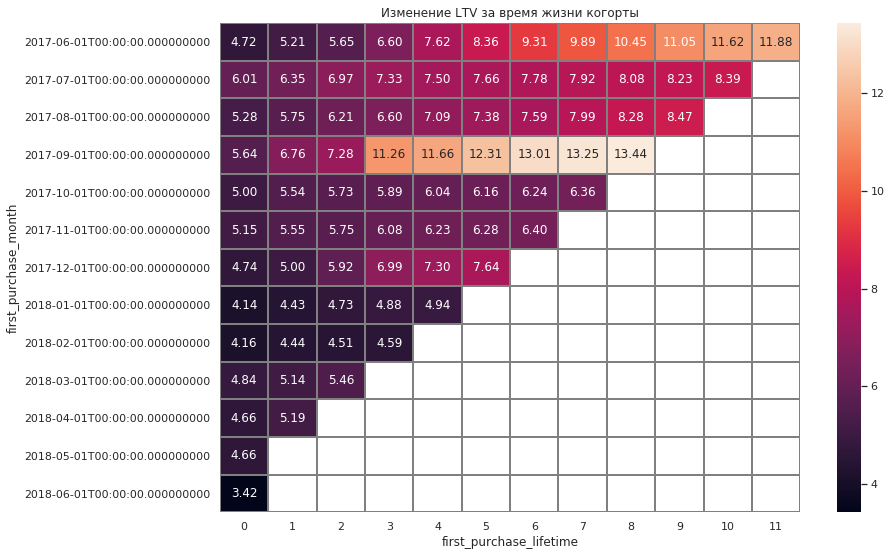

In [304]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Изменение LTV за время жизни когорты')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray');

Начиная со второго месяца жизни, по показателю LTV лидировала когорта 2017-09, следом за ней по показателю LTV идёт когорта 2017-06.  
Следует также отметить, что начиная с когорты 2018-01 наметилось некоторое снижение LTV.

### Выводы
Медианное время до первой покупки: 16 минут.  

Пользователи 1й горты (июнь 2017го) оформили за 6 месяцев в среднем по 1,83 заказа.
У остальных когорт результаты близки - от 1,35 до 1,47 заказа. Худший показатель у когорты октября 2017го - 1,35.  
В среднем по всем когортам за 6 месяцев подбзователи оформили по 1.47 заказа.  

Средний чек изменяется по месяцам в пределах 4-6 у.е., но устойчивой тенденции к повышению или понижению не наблюдается.  
Самый большой средний чек в декабре 2017го, 5.85 у.е., самый маленький - в июне 2017го, 4.06 у.е. 

ПНа 6й месяц жизни наибольший средний доход принесли пользователи когорты 2017-09, 12,3 у.е. Пользователи когорты 2017-06 -- по 8,3 у.е. Пользователи остальных пяти когорт, проживших не менее 6 месяцев -- от от 6,2 до 7,7 у.е.  


Начиная со второго месяца жизни, по показателю LTV лидировала когорта 2017-09, следом за ней по показателю LTV в большинстве месяцев идёт когорта 2017-06.  
Следует также отметить, что начиная с когорты 2018-01 наметилось некоторое снижение LTV.

## Маркетинговые метрики

### Определим первоначальный рекламный источник для каждого пользователя

In [305]:
visits['source_id'].unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [306]:
first_source = visits.sort_values(['uid','start_ts']).groupby('uid')['source_id'].first().reset_index()

In [307]:
first_source.head()

,uid,source_id
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [308]:
first_source = first_source.rename(columns={'source_id':'first_source'})

In [309]:
len(visits)

359400

In [310]:
visits = visits.merge(first_source, on = 'uid')

In [311]:
len(visits)

359400

In [312]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date,first_session_month,activity_month,cohort_lifetime,first_source
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,1080,2017-12-20,2017-12-01,2017-12-01,0,4
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,1680,2018-02-19,2018-02-01,2018-02-01,0,2
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,0,2017-07-01,2017-07-01,2017-07-01,0,5
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,1440,2018-03-09,2018-03-01,2018-05-01,2,4
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,3,10,2018-03-09,1680,2018-03-09,2018-03-01,2018-03-01,0,4


### Считаем общую сумму расходов на маркетинг

In [313]:
total_costs = costs['costs'].sum()
print('Общие расходы на маркетинг за период: {} у.е.'.format(total_costs))

Общие расходы на маркетинг за период: 329131.62 у.е.


Посчитаем общие расходы на маркетинг по месяцам

In [314]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [315]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [316]:
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()

In [317]:
monthly_costs.sort_values(by = 'month')

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


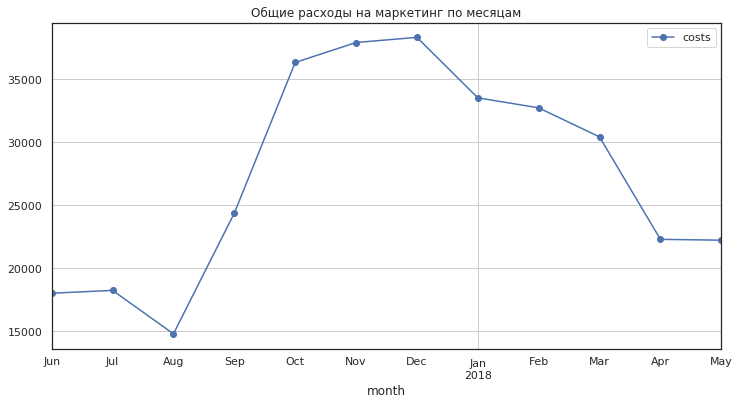

In [318]:
monthly_costs.plot(x='month', y='costs', grid=True, figsize=(12,6), title = 'Общие расходы на маркетинг по месяцам', marker='o');

Общие расходы на маркетинг начали существенно расти в сентябре 2017 с менее чем 20000 до 25000 у.е., были на максимум в районе 37000у.е. в период октября-декабря 2017го, затем начали немного снижаться , и в апреле резко упали до уровня 22000  у.е. в месяц.  
Возможно расходы на маркетинг целенаправленно повышают в осенне-зимний период.

### Распределение трат на маркетинг по источникам

In [319]:
monthly_costs_source = pd.pivot_table(costs, index='month', columns = 'source_id', values = 'costs', aggfunc='sum')

In [320]:
monthly_costs_source

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


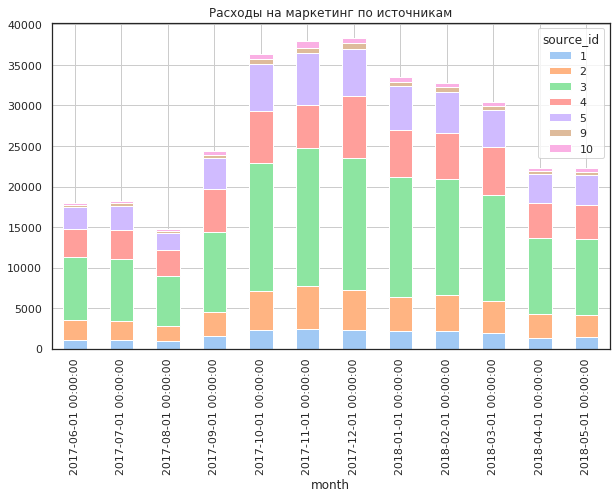

In [321]:
sns.set_style("white")
sns.set_palette("pastel")
monthly_costs_source.plot(kind="bar", figsize = (10,6), grid=True, stacked=True, title='Расходы на маркетинг по источникам')
plt.show()

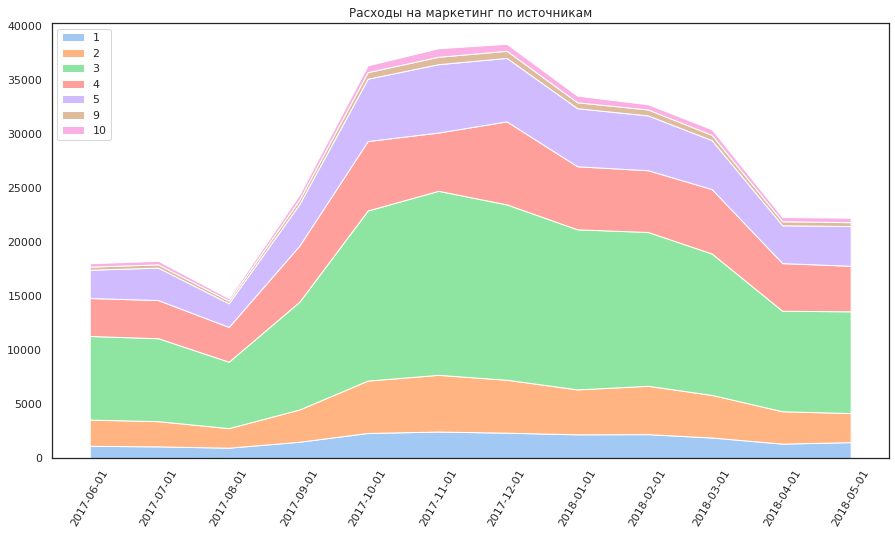

In [322]:
sns.set_style("white")
sns.set_palette("pastel")
plt.figure(figsize=(15,8))
x = monthly_costs_source.index
y = [monthly_costs_source[1], monthly_costs_source[2], monthly_costs_source[3], monthly_costs_source[4], monthly_costs_source[5], monthly_costs_source[9], monthly_costs_source[10]]
plt.stackplot(x,y, labels=monthly_costs_source.columns)
plt.title('Расходы на маркетинг по источникам')
plt.legend(loc='upper left')
plt.xticks(x, rotation = 60)
plt.show()

Во всех месяцах самые большие расходы на источник трафика 3.  Приблизительно одинаковые расходы приходятся на источники трафика 2, 4, 5.
На источники 9 и 10 приходится меньше всего расходов.  
Пропорции распределения расходов по источникам приблизительно одинаковые во всех месяцах.

###  Рассчитываем средний CAC на одного покупателя 

 Рассчитаем средний CAC на одного покупателя для всего проекта


In [323]:
total_cac = costs['costs'].sum() / orders['uid'].nunique()
print('Стоимость привелечения одного покупателя: {:.2f} у.е.'.format(total_cac))

Стоимость привелечения одного покупателя: 9.01 у.е.


 Рассчитаем средний CAC на одного покупателя для каждого источника трафика

Добавим в таблицу к заказам информацию об "основном" источнике трафика пользователя

In [324]:
orders = orders.merge(first_source, on = 'uid', how = 'left')

Убедимся, что количество строк в orders не изменилось

In [325]:
len(orders)

50415

In [326]:
orders.head(10)

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month,first_purchase_lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01 08:43:00,2017-06-01,2017-06-01,0,3
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01 08:54:00,2017-06-01,2017-06-01,0,5
7,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,1
8,2017-06-01 09:22:00,3.30,17542070709969841479,2017-06-01 09:22:00,2017-06-01,2017-06-01,0,4
9,2017-06-01 09:23:00,0.37,1074355127080856382,2017-06-01 09:23:00,2017-06-01,2017-06-01,0,1


In [327]:
users_cnt = orders.groupby('first_source')['uid'].agg('nunique').reset_index()

In [328]:
users_cnt

,first_source,uid
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Посчитаем суммарные расходы на каждый источник трафика

In [329]:
source_cost = costs.groupby('source_id')['costs'].sum().reset_index()

In [330]:
source_cost

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [331]:
users_cnt = pd.merge(users_cnt, source_cost, left_on='first_source', right_on = 'source_id')

In [332]:
users_cnt

,first_source,uid,source_id,costs
0,1,2899,1,20833.27
1,2,3506,2,42806.04
2,3,10473,3,141321.63
3,4,10296,4,61073.60
4,5,6931,5,51757.10
5,9,1088,9,5517.49
6,10,1329,10,5822.49


In [333]:
users_cnt['cac'] = users_cnt['costs'] / users_cnt['uid']

In [334]:
users_cnt

,first_source,uid,source_id,costs,cac
0,1,2899,1,20833.27,7.186364
1,2,3506,2,42806.04,12.209367
2,3,10473,3,141321.63,13.493901
3,4,10296,4,61073.60,5.931779
4,5,6931,5,51757.10,7.467479
5,9,1088,9,5517.49,5.071222
6,10,1329,10,5822.49,4.381106


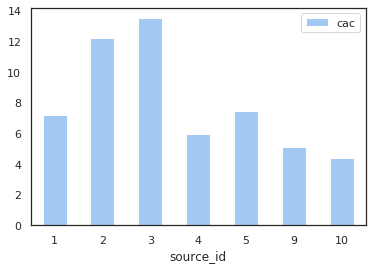

In [335]:
users_cnt.plot(x='source_id', y='cac', kind = 'bar', rot = 0);

Самые большие расходы - на привлечение пользователей из источников 2 и 3,  12,2 и 13,5 у.е. соответственно.  
Дешевле всего обходится привлечение пользователя из источника 10 -- 4,4 у.е. 

In [336]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [337]:
source_cost_month = costs.groupby(['source_id','month'])['costs'].sum().reset_index()

In [338]:
source_cost_month.head(15)

,source_id,month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
5,1,2017-11-01,2445.16
6,1,2017-12-01,2341.20
7,1,2018-01-01,2186.18
8,1,2018-02-01,2204.48
9,1,2018-03-01,1893.09


In [339]:
orders

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month,first_purchase_lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,3


In [340]:
users_cnt_month = orders.groupby(['first_source', 'first_purchase_month'])['uid'].agg('nunique').reset_index()

In [341]:
users_cnt_month.head(20)

,first_source,first_purchase_month,uid
0,1,2017-06-01,190
1,1,2017-07-01,160
2,1,2017-08-01,113
3,1,2017-09-01,227
4,1,2017-10-01,340
5,1,2017-11-01,324
6,1,2017-12-01,331
7,1,2018-01-01,238
8,1,2018-02-01,275
9,1,2018-03-01,281


In [342]:
users_cnt_month = pd.merge(users_cnt_month, source_cost_month, left_on=('first_source','first_purchase_month'), right_on = ('source_id','month'))

In [343]:
users_cnt_month['cac'] = users_cnt_month['costs'] / users_cnt_month['uid']

In [344]:
users_cnt_month.head(20)

,first_source,first_purchase_month,uid,source_id,month,costs,cac
0,1,2017-06-01,190,1,2017-06-01,1125.61,5.924263
1,1,2017-07-01,160,1,2017-07-01,1072.88,6.705500
2,1,2017-08-01,113,1,2017-08-01,951.81,8.423097
3,1,2017-09-01,227,1,2017-09-01,1502.01,6.616784
4,1,2017-10-01,340,1,2017-10-01,2315.75,6.811029
5,1,2017-11-01,324,1,2017-11-01,2445.16,7.546790
6,1,2017-12-01,331,1,2017-12-01,2341.20,7.073112
7,1,2018-01-01,238,1,2018-01-01,2186.18,9.185630
8,1,2018-02-01,275,1,2018-02-01,2204.48,8.016291
9,1,2018-03-01,281,1,2018-03-01,1893.09,6.736975


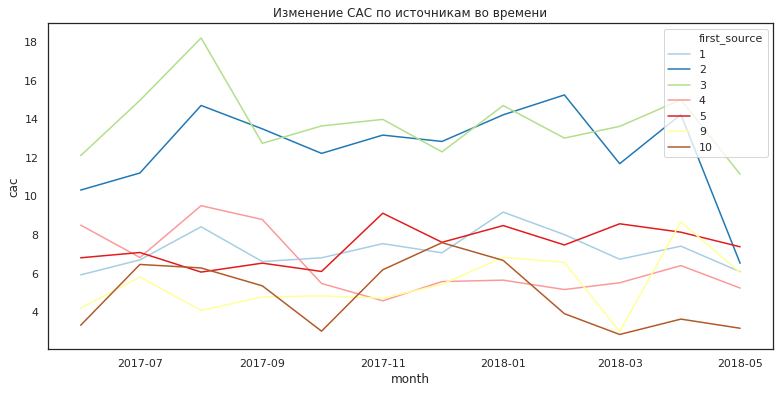

In [345]:
fig, ax = plt.subplots(figsize=(13, 6))
sns.set_palette('Paired')
sns.lineplot(data=users_cnt_month, x="month", y="cac", hue="first_source" , 
             legend = 'full', palette='Paired').set_title("Изменение САС по источникам во времени")

plt.show()

Стоимость привлечения пользователей из источников 2 и 3 была максимальной практически на всем рассматриваемом периоде.

### ROMI по когортам в разрезе источников

Посчитаем расходы по источникам в каждом месяце

In [346]:
costs_source_m = costs.groupby(['month','source_id'])['costs'].sum().reset_index()

In [347]:
costs_source_m.head(10)

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
5,2017-06-01,9,285.22
6,2017-06-01,10,314.22
7,2017-07-01,1,1072.88
8,2017-07-01,2,2333.11
9,2017-07-01,3,7674.37


Найдем стоимость привлечения одного посетителя для каждой когорты в разбивке по источникам

In [348]:
orders

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month,first_purchase_lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,2018-05-01,2018-05-01,0,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,2018-05-01,2018-05-01,0,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,2018-05-01,2018-05-01,0,3


In [349]:
cohorts_source_m_cac = orders.groupby(['first_purchase_month','first_source']).agg({'uid':'nunique'}).reset_index()

In [350]:
cohorts_source_m_cac = pd.merge(cohorts_source_m_cac, costs_source_m, how='left', left_on=['first_purchase_month', 'first_source'], right_on = ['month', 'source_id'])

In [351]:
cohorts_source_m_cac['cac'] = cohorts_source_m_cac['costs'] / cohorts_source_m_cac['uid']

In [352]:
cohorts_source_m_cac.head(15)

,first_purchase_month,first_source,uid,month,source_id,costs,cac
0,2017-06-01,1,190,2017-06-01,1.0,1125.61,5.924263
1,2017-06-01,2,235,2017-06-01,2.0,2427.38,10.329277
2,2017-06-01,3,638,2017-06-01,3.0,7731.65,12.118574
3,2017-06-01,4,413,2017-06-01,4.0,3514.80,8.510412
4,2017-06-01,5,384,2017-06-01,5.0,2616.12,6.812813
5,2017-06-01,9,68,2017-06-01,9.0,285.22,4.194412
6,2017-06-01,10,95,2017-06-01,10.0,314.22,3.307579
7,2017-07-01,1,160,2017-07-01,1.0,1072.88,6.705500
8,2017-07-01,2,208,2017-07-01,2.0,2333.11,11.216875
9,2017-07-01,3,512,2017-07-01,3.0,7674.37,14.989004


Добавим lifetime когорт

In [353]:
cohorts_source_m = orders.groupby(['first_purchase_month','first_source','first_purchase_lifetime']).agg({'uid':'nunique'}).reset_index()

In [354]:
cohorts_source_m.head(10)

,first_purchase_month,first_source,first_purchase_lifetime,uid
0,2017-06-01,1,0,190
1,2017-06-01,1,1,16
2,2017-06-01,1,2,10
3,2017-06-01,1,3,9
4,2017-06-01,1,4,12
5,2017-06-01,1,5,15
6,2017-06-01,1,6,9
7,2017-06-01,1,7,11
8,2017-06-01,1,8,8
9,2017-06-01,1,9,7


Добавим а полученный датафрейм рассчитанный ранее CAC

In [355]:
cohorts_source_m = pd.merge(cohorts_source_m, cohorts_source_m_cac[['first_purchase_month','first_source', 'cac']], how='left', on=['first_purchase_month', 'first_source'])

In [356]:
cohorts_source_m.head(15)

,first_purchase_month,first_source,first_purchase_lifetime,uid,cac
0,2017-06-01,1,0,190,5.924263
1,2017-06-01,1,1,16,5.924263
2,2017-06-01,1,2,10,5.924263
3,2017-06-01,1,3,9,5.924263
4,2017-06-01,1,4,12,5.924263
5,2017-06-01,1,5,15,5.924263
6,2017-06-01,1,6,9,5.924263
7,2017-06-01,1,7,11,5.924263
8,2017-06-01,1,8,8,5.924263
9,2017-06-01,1,9,7,5.924263


Посчитаем какой доход принесли пользователи в разрезе когорт и источников

In [357]:
orders.head()

,buy_ts,revenue,uid,first_purchase_date,first_purchase_month,month,first_purchase_lifetime,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01,0,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01,0,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01,0,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01,0,3


In [358]:
cumrevenue_source = orders.groupby(['first_purchase_month','first_source', 'first_purchase_lifetime']).agg({'revenue': 'sum'}).reset_index()

In [359]:
cumrevenue_source.head(10)

,first_purchase_month,first_source,first_purchase_lifetime,revenue
0,2017-06-01,1,0,1378.70
1,2017-06-01,1,1,414.98
2,2017-06-01,1,2,419.43
3,2017-06-01,1,3,714.24
4,2017-06-01,1,4,811.20
5,2017-06-01,1,5,389.34
6,2017-06-01,1,6,490.48
7,2017-06-01,1,7,479.23
8,2017-06-01,1,8,432.15
9,2017-06-01,1,9,316.30


In [360]:
cohorts_source_m_cac.head(20)

,first_purchase_month,first_source,uid,month,source_id,costs,cac
0,2017-06-01,1,190,2017-06-01,1.0,1125.61,5.924263
1,2017-06-01,2,235,2017-06-01,2.0,2427.38,10.329277
2,2017-06-01,3,638,2017-06-01,3.0,7731.65,12.118574
3,2017-06-01,4,413,2017-06-01,4.0,3514.80,8.510412
4,2017-06-01,5,384,2017-06-01,5.0,2616.12,6.812813
5,2017-06-01,9,68,2017-06-01,9.0,285.22,4.194412
6,2017-06-01,10,95,2017-06-01,10.0,314.22,3.307579
7,2017-07-01,1,160,2017-07-01,1.0,1072.88,6.705500
8,2017-07-01,2,208,2017-07-01,2.0,2333.11,11.216875
9,2017-07-01,3,512,2017-07-01,3.0,7674.37,14.989004


Соберем необходимые данные в один отчет

In [361]:
report = cumrevenue_source.merge(cohorts_source_m_cac[['first_purchase_month','first_source', 'cac']], on = ['first_purchase_month','first_source'])

In [362]:
report.head(10)

,first_purchase_month,first_source,first_purchase_lifetime,revenue,cac
0,2017-06-01,1,0,1378.70,5.924263
1,2017-06-01,1,1,414.98,5.924263
2,2017-06-01,1,2,419.43,5.924263
3,2017-06-01,1,3,714.24,5.924263
4,2017-06-01,1,4,811.20,5.924263
5,2017-06-01,1,5,389.34,5.924263
6,2017-06-01,1,6,490.48,5.924263
7,2017-06-01,1,7,479.23,5.924263
8,2017-06-01,1,8,432.15,5.924263
9,2017-06-01,1,9,316.30,5.924263


Добавим в отчет данные о начальном количестве пользователей в когортаз с разбивкой по источникам

In [363]:
users_source = orders.groupby(['first_purchase_month', 'first_source'])['uid'].nunique().reset_index()

In [364]:
users_source = users_source.rename(columns = {'uid':'initial_users_count'})

In [365]:
users_source.head(15)

,first_purchase_month,first_source,initial_users_count
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
5,2017-06-01,9,68
6,2017-06-01,10,95
7,2017-07-01,1,160
8,2017-07-01,2,208
9,2017-07-01,3,512


In [366]:
report = report.merge(users_source, on=['first_purchase_month', 'first_source'])

In [367]:
report['ltv']= report['revenue']/report['initial_users_count']

In [368]:
report['romi']= report['ltv']/report['cac']

In [369]:
report.head(15)

,first_purchase_month,first_source,first_purchase_lifetime,revenue,cac,initial_users_count,ltv,romi
0,2017-06-01,1,0,1378.70,5.924263,190,7.256316,1.224847
1,2017-06-01,1,1,414.98,5.924263,190,2.184105,0.368671
2,2017-06-01,1,2,419.43,5.924263,190,2.207526,0.372625
3,2017-06-01,1,3,714.24,5.924263,190,3.759158,0.634536
4,2017-06-01,1,4,811.20,5.924263,190,4.269474,0.720676
5,2017-06-01,1,5,389.34,5.924263,190,2.049158,0.345892
6,2017-06-01,1,6,490.48,5.924263,190,2.581474,0.435746
7,2017-06-01,1,7,479.23,5.924263,190,2.522263,0.425751
8,2017-06-01,1,8,432.15,5.924263,190,2.274474,0.383925
9,2017-06-01,1,9,316.30,5.924263,190,1.664737,0.281003


Посмотрим на графике как изменялся ROMI

In [370]:
sources = report['first_source'].unique()

In [371]:
sources

array([ 1,  2,  3,  4,  5,  9, 10,  7])

In [372]:
sources = [ 1,  2,  3,  4,  5,  9, 10]

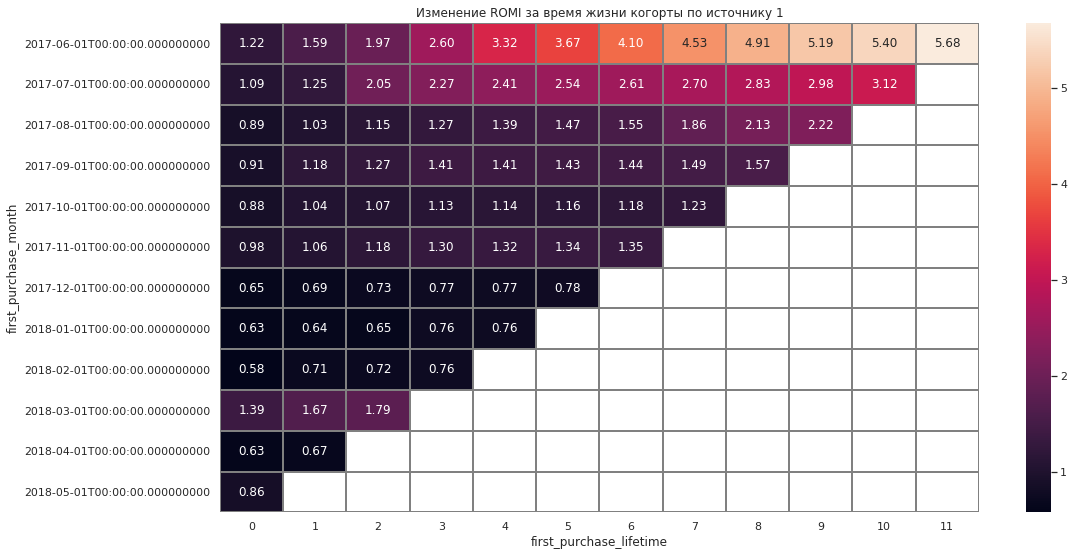

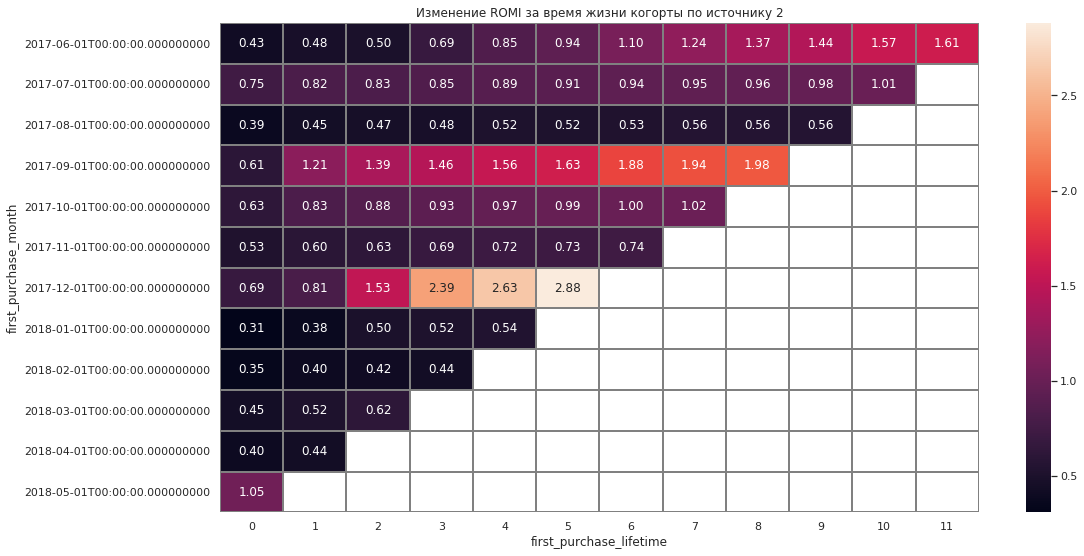

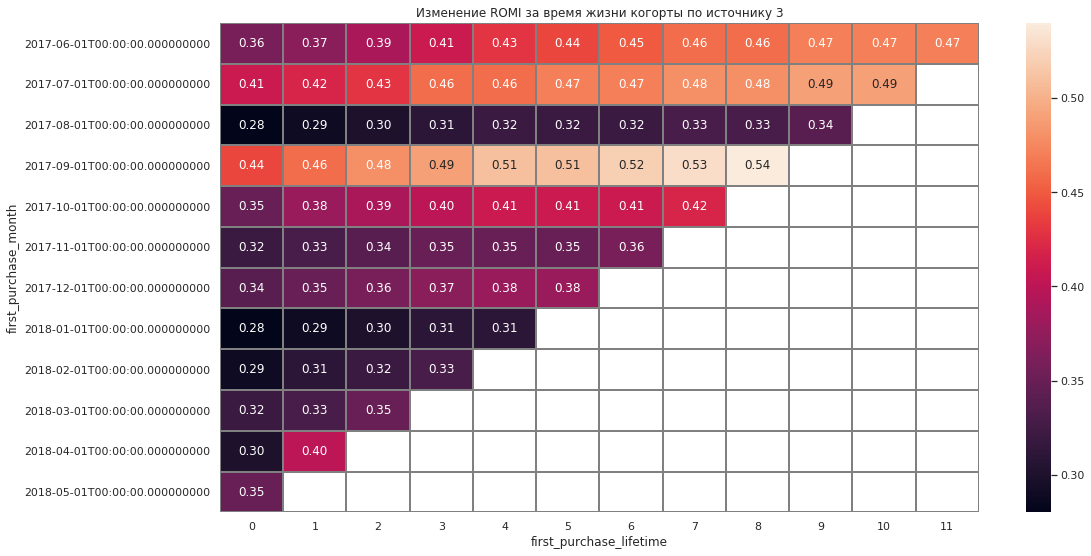

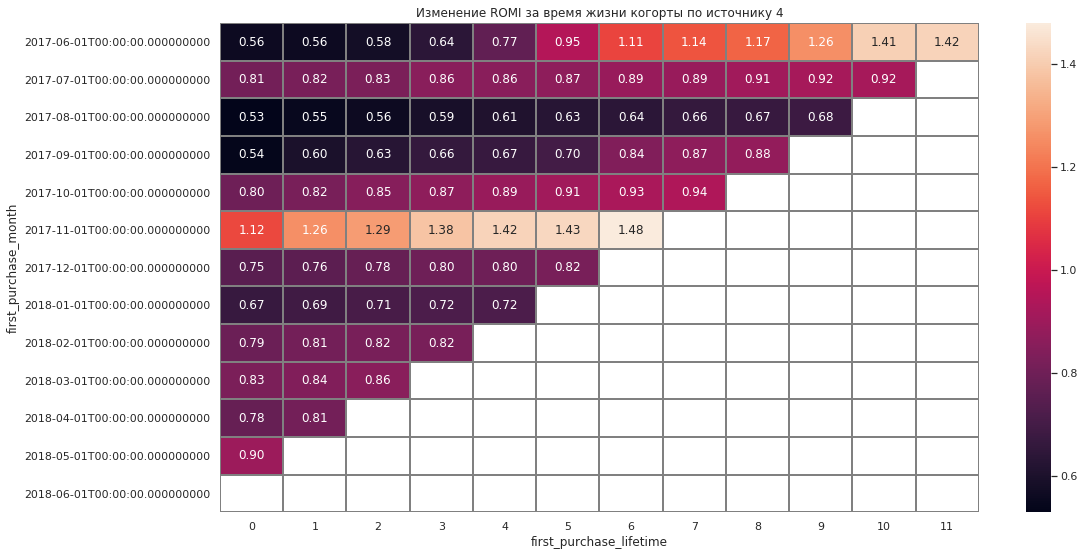

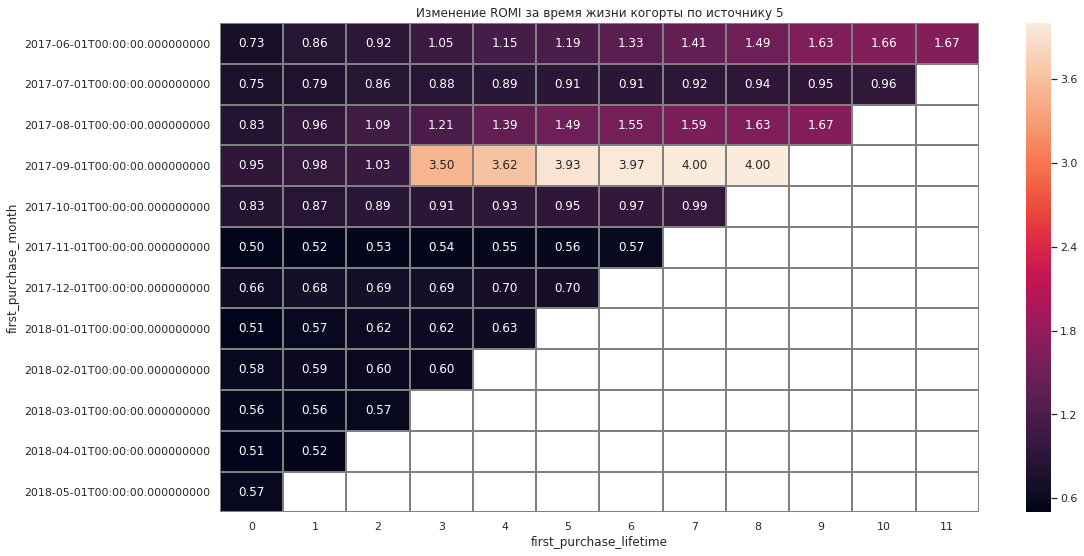

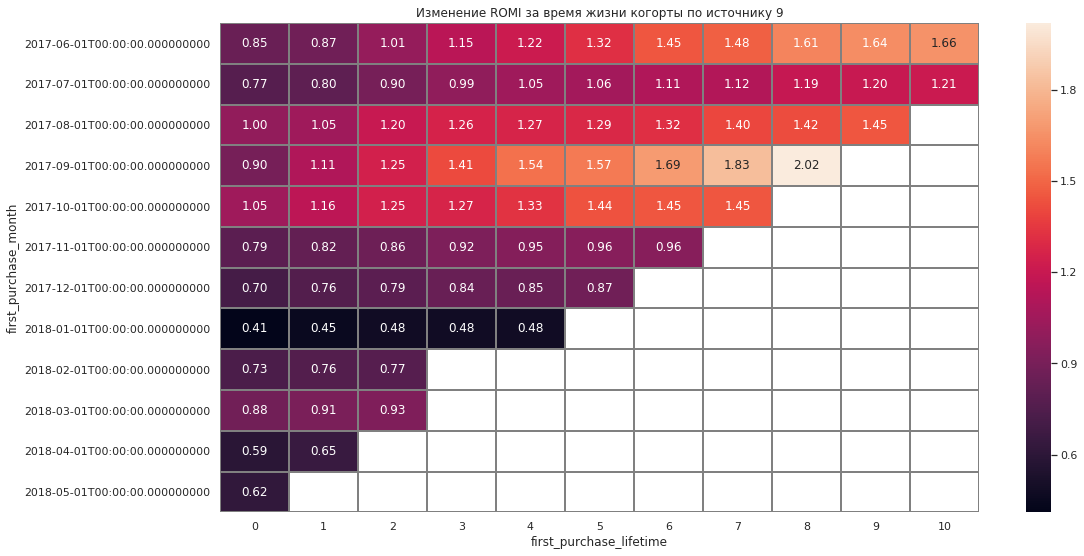

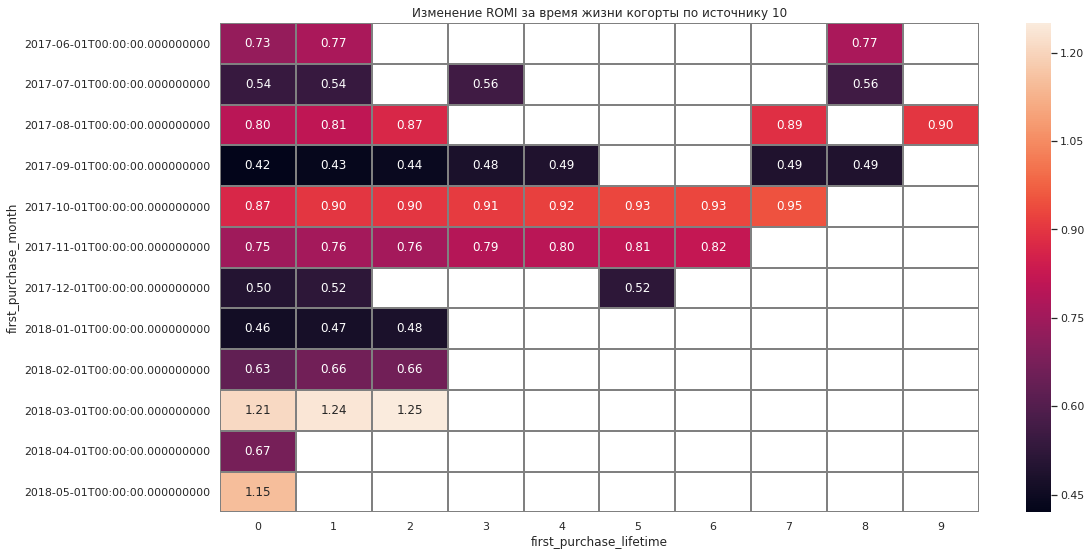

In [373]:
for source in sources:
  rep = report.query('first_source == @source').pivot('first_purchase_month','first_purchase_lifetime','romi')
  sns.set(style='white')
  plt.figure(figsize=(17, 9))
  plt.title(f'Изменение ROMI за время жизни когорты по источнику {source}')
  ax = sns.heatmap(rep.cumsum(axis=1).round(2), annot=True, fmt='.2f', linewidths=1, linecolor='gray') 
  plt.show()


Помотрим по скольким когортам затраты окупились на 3й месяц жизни.  
По источнику 1: 7 когорт  
По источнику 2: 2 когорты  
По источнику 3: 0 когорт  
По источнику 4: 1 когорта  
По источнику 5: 2 когорты  
По источнику 9: 4 когорты  
По источнику 10: 0 когорт   

Отметим также, что по источникам трафика 3 и 10 расходы на маркетинг не окупились ни для одной когорты за весь расматриваемый период.

Добавим в отчет кумулятивное значение ROMI

In [374]:
report['cum_romi'] = report.groupby(['first_purchase_month','first_source'])['romi'].cumsum(axis=0)

In [375]:
report.head(15)

,first_purchase_month,first_source,first_purchase_lifetime,revenue,cac,initial_users_count,ltv,romi,cum_romi
0,2017-06-01,1,0,1378.70,5.924263,190,7.256316,1.224847,1.224847
1,2017-06-01,1,1,414.98,5.924263,190,2.184105,0.368671,1.593518
2,2017-06-01,1,2,419.43,5.924263,190,2.207526,0.372625,1.966143
3,2017-06-01,1,3,714.24,5.924263,190,3.759158,0.634536,2.600679
4,2017-06-01,1,4,811.20,5.924263,190,4.269474,0.720676,3.321355
5,2017-06-01,1,5,389.34,5.924263,190,2.049158,0.345892,3.667247
6,2017-06-01,1,6,490.48,5.924263,190,2.581474,0.435746,4.102993
7,2017-06-01,1,7,479.23,5.924263,190,2.522263,0.425751,4.528744
8,2017-06-01,1,8,432.15,5.924263,190,2.274474,0.383925,4.912670
9,2017-06-01,1,9,316.30,5.924263,190,1.664737,0.281003,5.193673


Посмотрим, во сколько раз в среднем окупились затраты на маркетинг на 3й месяц жизни когорт

In [376]:
report.query('first_purchase_lifetime == 2').groupby('first_source')['cum_romi'].mean().sort_values(ascending=False)

first_source
1     1.258675
9     0.943664
4     0.791630
5     0.779610
2     0.777428
10    0.765743
3     0.367152
Name: cum_romi, dtype: float64

Лучшие показатели окупаемости у источников 1 и 9

### Выводы
Общие расходы на маркетинг за период: 329131.62 у.е.  
Общие расходы на маркетинг начали существенно расти в сентябре 2017 с менее чем 20000 до 25000 у.е., были на максимум в районе 37000у.е. в период октября-декабря 2017го, затем начали немного снижаться , и в апреле резко упали до уровня 22000 у.е. в месяц.
Возможно расходы на маркетинг целенаправленно повышают в осенне-зимний период.

Во всех месяцах самые большие расходы на источник трафика 3.  Приблизительно одинаковые расходы приходятся на источники трафика 2, 4, 5. Чуть меньше - на 1й.
На источники 9 и 10 приходится меньше всего расходов.  
Пропорции распределения расходов по источникам приблизительно одинаковые во всех месяцах.  

Самые большие расходы - на привлечение пользователей из источников 2 и 3, 12,2 и 13,5 у.е. соответственно.
Дешевле всего обходится привлечение пользователя из источника 10 -- 4,4 у.е.    

Помотрим по скольким когортам затраты окупились на 3й месяц жизни.
По источнику 1: 7 когорт
По источнику 2: 2 когорты
По источнику 3: 0 когорт
По источнику 4: 1 когорта
По источнику 5: 2 когорты
По источнику 9: 4 когорты
По источнику 10: 0 когорт

Отметим также, что по источникам трафика 3 и 10 расходы на маркетинг не окупились ни для одной когорты за весь расматриваемый период.  

По следующим источникам затраты средние показатели окупаемости оказались наивысшими на 3й месяц жизни когорт (среди всех когорт):  
1     1.25  
9     0.94  
4     0.79  
5     0.77

Бытрее всего окупаются затраты по источникам 1, 9, 4, 5.  

## Выводы 
**Продуктовые метрики.**  
С июля 2017го года до октября 2017го на сайте регистрировалось около 500 пользователей в день. Затем в период с октября 2017 до апреля 2018 - около 1200 пользователей в день, после чего количество регистраций вновь упало и колебалось в диапозоне от 500 до 1000 до июля 2018го. Наблюдаются пики в ноябре 2017го и в конце мая 2018гою Также в марте 2018го есть один день с нудевым количеством регистраций - возможно, сервис в этот день не работал, или была проблема с регистрацией. В среднем за рассматриваемый период регистрировалось по 908 пользователей в день.

Среднее количество сессий в день на одного пользователя достаточно стабильно на всём периоде наблюдений и колеблется от 1.05 до 1.1 сессии в день.
Типичный пользователь проводит на сайте 5 минут.

Retention rate ниже в более молодых когортах (снижается с декабря 2017го). Для 1го месяца жизни когорты retention rate снизился примерно с 8 до 5%.
Также в рамках каждой когорты в целом наблюдается постепенное снижение retention rate, хотя в двух первых когортах в некоторых месяцах был небольшой рост. При том чем моложе когорта, тем быстрее снижается retention rate. К примеру в первых двух когортах на 6й месяц оставалось 5-6% пользователей, а в 4 и 5й когортах только около 2%.
Средний Retention Rate на второй месяц «жизни» когорт: 6.5%

**Метрики элетронной коммерции.**  
Медианное время до первой покупки: 16 минут.

Пользователи 1й горты (июнь 2017го) оформили за 6 месяцев в среднем по 1,83 заказа.
У остальных когорт результаты близки - от 1,35 до 1,47 заказа. Худший показатель у когорты октября 2017го - 1,35.
В среднем по всем когортам за 6 месяцев подбзователи оформили по 1.47 заказа.

Средний чек изменяется по месяцам в пределах 4-6 у.е., но устойчивой тенденции к повышению или понижению не наблюдается.  
Самый большой средний чек в декабре 2017го, 5.85 у.е., самый маленький - в июне 2017го, 4.06 у.е.  

На 6й месяц жизни наибольший средний доход принесли пользователи когорты 2017-09, 12,3 у.е. Пользователи когорты 2017-06 -- по 8,3 у.е. Пользователи остальных пяти когорт, проживших не менее 6 месяцев -- от от 6,2 до 7,7 у.е.

Начиная со второго месяца жизни, по показателю LTV лидировала когорта 2017-09, следом за ней по показателю LTV идёт когорта 2017-06.  
Следует также отметить, что начиная с когорты 2018-01 наметилось некоторое снижение LTV.

**Маркетинговые метрики.**   
Общие расходы на маркетинг за период: 329131.62 у.е.  
Общие расходы на маркетинг начали существенно расти в сентябре 2017 с менее чем 20000 до 25000 у.е., были на максимум в районе 37000у.е. в период октября-декабря 2017го, затем начали немного снижаться , и в апреле резко упали до уровня 22000 у.е. в месяц.
Возможно расходы на маркетинг целенаправленно повышают в осенне-зимний период.

Во всех месяцах самые большие расходы на источник трафика 3.  Приблизительно одинаковые расходы приходятся на источники трафика 2, 4, 5. Чуть меньше - на 1й.
На источники 9 и 10 приходится меньше всего расходов.  
Пропорции распределения расходов по источникам приблизительно одинаковые во всех месяцах.  

Самые большие расходы - на привлечение пользователей из источников 2 и 3, 12,2 и 13,5 у.е. соответственно.
Дешевле всего обходится привлечение пользователя из источника 10 -- 4,4 у.е. 

Помотрим по скольким когортам затраты окупились на 3й месяц жизни.  
По источнику 1: 7 когорт  
По источнику 2: 2 когорты  
По источнику 3: 0 когорт  
По источнику 4: 1 когорта  
По источнику 5: 2 когорты  
По источнику 9: 4 когорты  
По источнику 10: 0 когорт  

Отметим также, что по источникам трафика 3 и 10 расходы на маркетинг не окупились ни для одной когорты за весь расматриваемый период.  

По следующим источникам затраты средние показатели окупаемости оказались наивысшими на 3й месяц жизни когорт (среди всех когорт):  
1     1.25  
9     0.94  
4     0.79  
5     0.77

Бытрее всего окупаются затраты по источникам 1, 9, 4, 5. 

Исходя из изложенного выше, маркетологам можно рекомендовать сместить фокус с источника трафика 3 на источники 1 и 9, на которые сейчас приходится небольшая доля расходов.